## Model for x-ray segmantation

### Download data

In [ ]:
%%bash
pip install -q -U mdai

In [ ]:
import mdai
mdai.__version__

'0.7.7'

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

In [ ]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="4f045b0b9379f09ef01f5bcb5d632071")
#!!!remove personal token before publication!!!11111

Successfully authenticated to public.md.ai.


In [ ]:
p = mdai_client.project('aGq4k6NW', path='./segmentation_data')

Using path './segmentation_data' for data.
Preparing annotations export for project aGq4k6NW...                                                
Preparing images export for project aGq4k6NW...                                                     


3.75MB [00:00, 151MB/s]                    
  0%|          | 0.00/11.4M [00:00<?, ?B/s]

Success: annotations data for project aGq4k6NW ready.


11.4MB [00:00, 74.8MB/s]                            


Extracting archive: mdai_public_project_aGq4k6NW_images_2021-04-20-155137.zip
Success: images data for project aGq4k6NW ready.


In [ ]:
p.show_label_groups()

Label Group, Id: G_Vdj4o2, Name: Default group
	Labels:
	Id: L_A8Jm3d, Name: Lung



In [ ]:
# this maps label ids to class ids as a dict obj
labels_dict = {
    'L_A8Jm3d': 1, # Lung   
}

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_A8Jm3d': 1}


In [ ]:
p.show_datasets() 

Datasets:
Id: D_rQLwzo, Name: Dataset



In [ ]:
dataset = p.get_dataset_by_id('D_rQLwzo')
dataset.prepare()

In [ ]:
image_ids = dataset.get_image_ids()
len(image_ids)

138

In [ ]:
for i in range(6):
    print(mdai.visualize.load_dicom_image(image_ids[i]).shape)

(978, 804)
(978, 804)
(978, 804)
(978, 804)
(978, 804)
(804, 978)


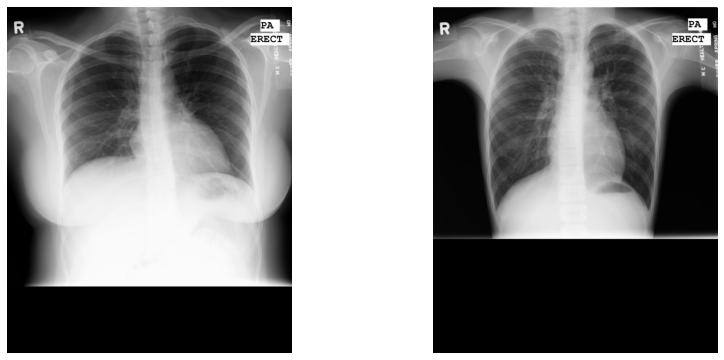

In [ ]:
mdai.visualize.display_images(image_ids[:2], cols=2)

### Load data

In [ ]:
import sys 
!{sys.executable} -m pip install tensorflow==2.4.1

In [ ]:
%%bash
pip install -q keras==2.3.0
pip install -q keras-unet

In [ ]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import exposure

In [ ]:
imgs_anns_dict = dataset.imgs_anns_dict

In [ ]:
def load_images(imgs_anns_dict, img_size=128):
    images = []
    masks = []

    for img_fp in imgs_anns_dict.keys():
        img = mdai.visualize.load_dicom_image(img_fp)
        ann = imgs_anns_dict[img_fp]

        img_width = img.shape[1]
        img_height = img.shape[0]

        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        assert img.shape == mask.shape

        for a in ann:
            vertices = np.array(a['data']['vertices'])
            vertices = vertices.reshape((-1, 2))
            cv2.fillPoly(mask, np.int32([vertices]), (255, 255, 255))

        # resizing and padding
        if img.shape[0] == img.shape[1]:
            resized_shape = (img_size, img_size)
            offset = (0, 0)

        # height > width
        elif img.shape[0] > img.shape[1]:
            resized_shape = (img_size, round(img_size * img.shape[1] / img.shape[0]))
            offset = (0, (img_size - resized_shape[1]) // 2)

        else:
            resized_shape = (round(img_size * img.shape[0] / img.shape[1]), img_size)
            offset = ((img_size - resized_shape[0]) // 2, 0)

        resized_shape = (resized_shape[1], resized_shape[0])
        img_resized = cv2.resize(img, resized_shape).astype(np.uint8)
        mask_resized = cv2.resize(mask, resized_shape).astype(np.bool)

        resized_shape = (resized_shape[1], resized_shape[0])

        # add padding to square
        img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
        img_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = img_resized
        mask_padded = np.zeros((img_size, img_size), dtype=np.bool)
        mask_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = mask_resized

        def norm(img):
            img = img.astype(np.float64)
            norm = (img - np.min(img)) / (np.max(img) - np.min(img))
            return norm
        
        images.append(norm(img_padded))
        masks.append(mask_padded)

    # add channel dim
    images = np.asarray(images)[:, :, :, None]
    masks = np.asarray(masks)[:, :, :, None]
    return images, masks

In [ ]:
images, masks = load_images(imgs_anns_dict)

49


(-0.5, 127.5, 127.5, -0.5)

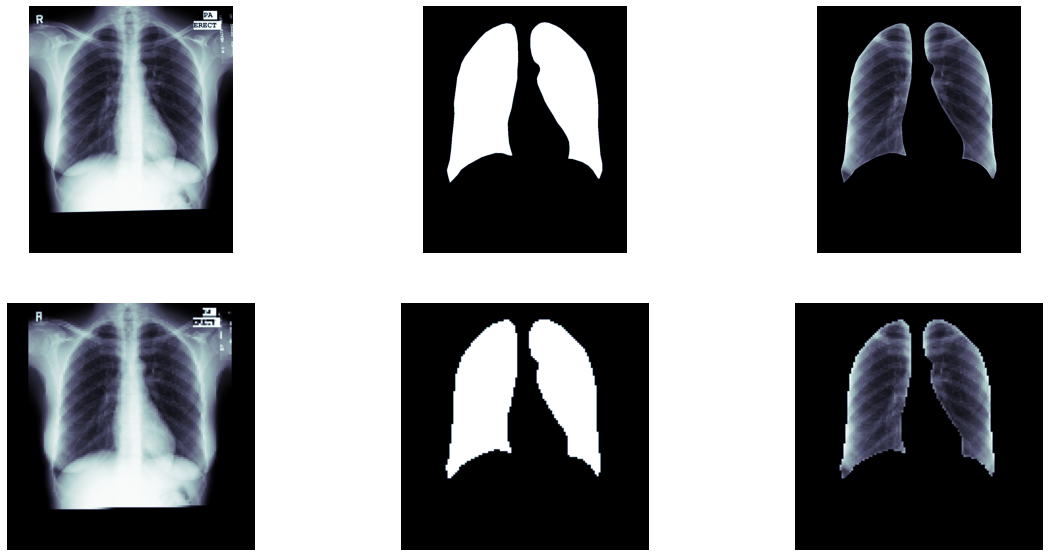

In [ ]:
img_index = random.choice(range(len(imgs_anns_dict)))

print(img_index)
img_fps = list(imgs_anns_dict.keys())
img_fp = img_fps[img_index]
img = mdai.visualize.load_dicom_image(img_fp)
ann = imgs_anns_dict[img_fp]
img_width = img.shape[1]
img_height = img.shape[0]

mask = np.zeros((img_height, img_width), dtype=np.uint8) 
for a in ann:     
    vertices = np.array(a['data']['vertices'])
    vertices = vertices.reshape((-1,2))                     
    cv2.fillPoly(mask, np.int32([vertices]), (255,255,255))
    
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.imshow(img, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,3)              
plt.imshow(cv2.bitwise_and(img, img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(images[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(masks[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(cv2.bitwise_and(images[img_index,:,:,0], images[img_index,:,:,0], 
                           mask=masks[img_index,:,:,0].astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

### Build model

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=0)

In [ ]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
    ))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
from keras_unet.models import custom_unet

model = custom_unet(
    x_train[0].shape,
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
)

### Train model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
    ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
]

Using TensorFlow backend.


In [ ]:
from keras_unet.metrics import iou


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', iou],
)

In [ ]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 750s 7s/step - loss: 0.2896 - accuracy: 0.8796 - iou: 0.5073 - val_loss: 61.1110 - val_accuracy: 0.2254 - val_iou: 0.2246

Epoch 00001: val_loss improved from inf to 61.11096, saving model to model.h5
Epoch 2/10
100/100 [==============================] - 748s 7s/step - loss: 0.0854 - accuracy: 0.9577 - iou: 0.7681 - val_loss: 1.5782 - val_accuracy: 0.8096 - val_iou: 0.5002

Epoch 00002: val_loss improved from 61.11096 to 1.57824, saving model to model.h5
Epoch 3/10
100/100 [==============================] - 716s 7s/step - loss: 0.0626 - accuracy: 0.9634 - iou: 0.8244 - val_loss: 0.1372 - val_accuracy: 0.9622 - val_iou: 0.7914

Epoch 00003: val_loss improved from 1.57824 to 0.13723, saving model to model.h5
Epoch 4/10
100/100 [==============================] - 735s 7s/step - loss: 0.0582 - accuracy: 0.9635 - iou: 0.8391 - val_loss: 0.1054 - val_accuracy: 0.9712 - val_iou: 0.8252

Epoch 00004: val_loss improved from 0.13723 to 0.10541

dict_keys(['loss', 'accuracy', 'iou', 'val_loss', 'val_accuracy', 'val_iou'])


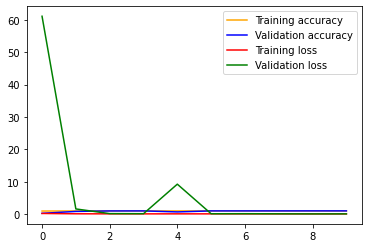

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

In [ ]:
def show_sample_results():
    images, masks = load_images(imgs_anns_dict)

    plt.figure(figsize=(20, 40))

    img_index = random.choice(range(len(images)))

    plt.subplot(1,4,1)
    random_img = images[img_index,:,:,0]
    plt.imshow(random_img, cmap=plt.cm.bone)
    plt.axis('off')
    plt.title('Lung X-Ray')

    plt.subplot(1,4,2)
    random_mask = masks[img_index,:,:,0]
    plt.imshow(random_mask, cmap=plt.cm.bone)
    plt.axis('off')
    plt.title('Mask Ground Truth')

    random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
    mask = model.predict(random_img_2)[0][:,:,0] > 0.5
    plt.subplot(1,4,3)
    plt.imshow(mask, cmap=plt.cm.bone)
    plt.axis('off')
    plt.title('Predicted Mask')

    plt.subplot(1,4,4)
    plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
    plt.axis('off')
    plt.title('Predicted Lung Segmentation')

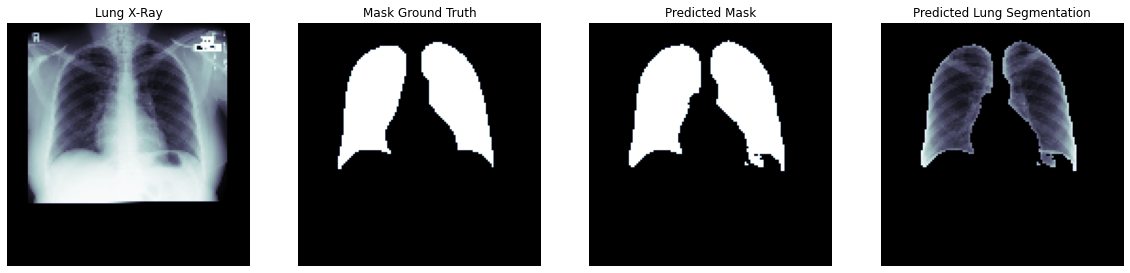

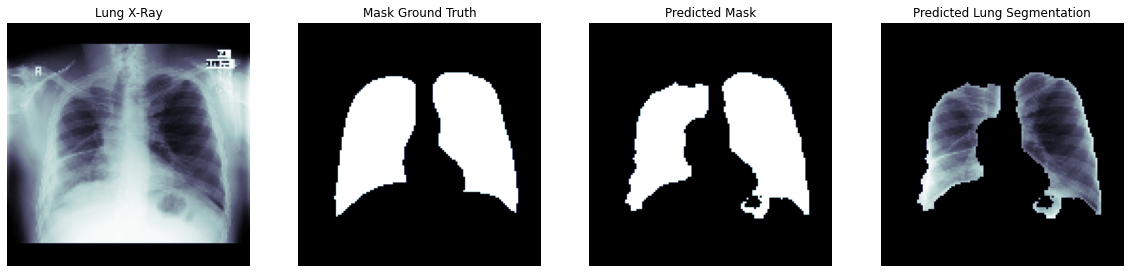

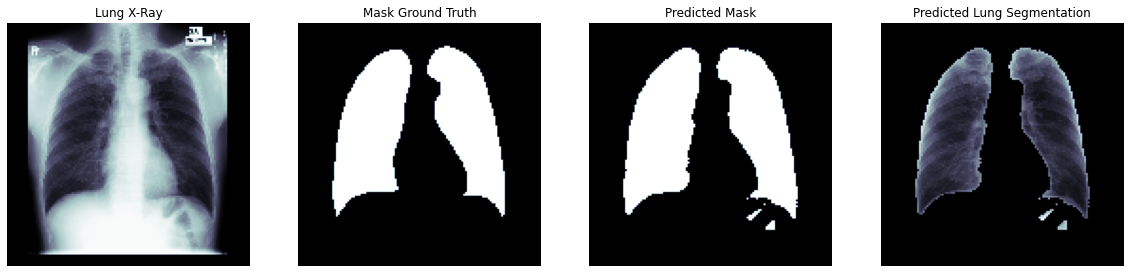

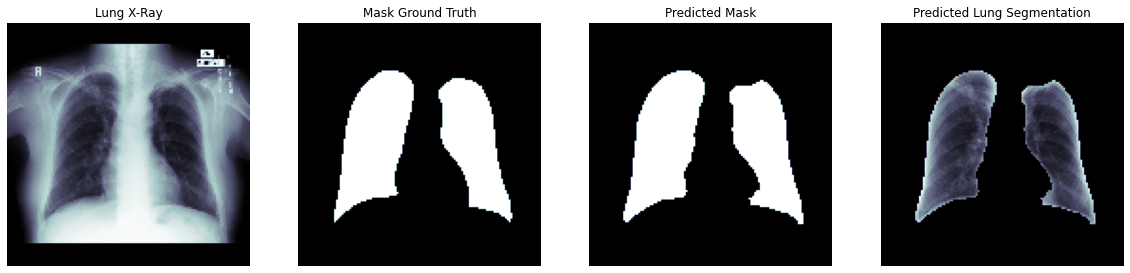

In [ ]:
show_sample_results()
show_sample_results()
show_sample_results()
show_sample_results()

In [ ]:
model.save('../segmentation_model_norm.h5')

In [ ]:
model.summary()

### Crop results

In [ ]:
def crop(img):
    coords = np.argwhere(img)
    y0, x0, y1, x1 = *np.min(coords, axis=0), *np.max(coords, axis=0)
    return img[y0:y1,x0:x1]
    
def resize(img,img_size=128):
    
    # resizing and padding
    if img.shape[0] == img.shape[1]:
        resized_shape = (img_size, img_size)
        offset = (0, 0)
    # height > width
    elif img.shape[0] > img.shape[1]:
        resized_shape = (img_size, round(img_size * img.shape[1] / img.shape[0]))
        offset = (0, (img_size - resized_shape[1]) // 2)

    else:
        resized_shape = (round(img_size * img.shape[0] / img.shape[1]), img_size)
        offset = ((img_size - resized_shape[0]) // 2, 0)

    resized_shape = (resized_shape[1], resized_shape[0])
    img_resized = cv2.resize(img, resized_shape)#.astype(np.uint8)
    resized_shape = (resized_shape[1], resized_shape[0])

    # add padding to square
    img_padded = np.zeros((img_size, img_size), dtype=np.float64)
    img_padded[
        offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
    ] = img_resized
    
    return img_padded 

def norm(img):
    img = img.astype(np.float64)
    norm = (img - np.min(img)) / (np.max(img) - np.min(img))
    return norm

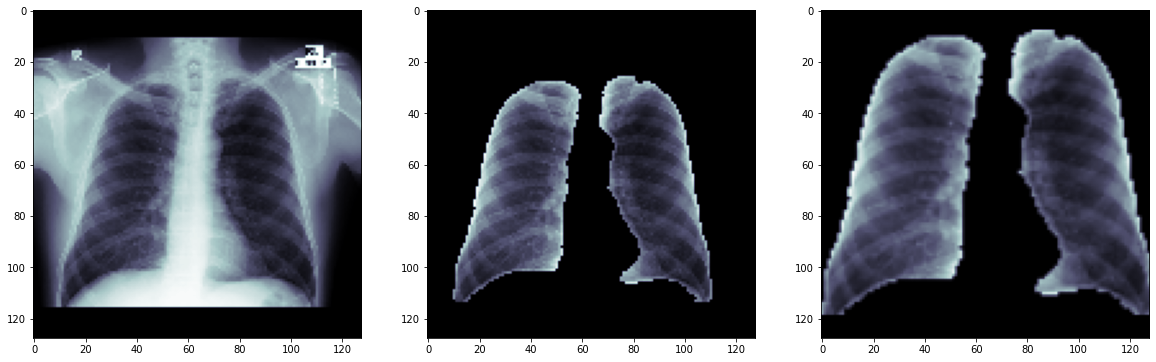

In [ ]:
# test resize
img = images[6,:,:,0]
img_2 = np.expand_dims(np.expand_dims(img, axis=0), axis=3)
mask = model.predict(img_2)[0][:,:,0] > 0.5
segment = cv2.bitwise_and(img, img, mask=mask.astype(np.uint8))

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
plt.imshow(img, cmap=plt.cm.bone)
plt.subplot(1,3,2)
plt.imshow(segment, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.imshow(resize(crop(segment),128), cmap=plt.cm.bone)

### Test on new data

In [ ]:
import pydicom
import pandas as pd
from os import walk, listdir

train_image = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv')
TRAIN_DIR = '../input/siim-covid19-detection/train'

#image_dir = train_image['StudyInstanceUID'][0]
#path_to_img = TRAIN_DIR + '/' + image_dir 
#path_to_img = path_to_img +'/' + listdir(path_to_img)[0] 
#path_to_img = path_to_img + '/' + next(walk(path_to_img))[2][0]
#print(path_to_img)
#data = pydicom.dcmread(path_to_img)
# get the pixel information into a numpy array
#img = data.pixel_array

new_images=[]
l=0
for study_id in set(train_image.StudyInstanceUID):
    path1 = TRAIN_DIR + '/' + study_id 
    for p in listdir(path1):
        if l<10:
            path_to_img = path1 +'/' + p
            path_to_img = path_to_img + '/' + next(walk(path_to_img))[2][0]
            data = pydicom.dcmread(path_to_img)
            img=data.pixel_array
            new_images.append(img)
            l+=1

In [ ]:
model.load_weights('../segmentation_model_norm.h5')

In [ ]:
def show_prediction_on_new_data(i=0):
    img = resize(norm(new_images[i]),128)
    img_2 = np.expand_dims(np.expand_dims(img, axis=0), axis=3)
    mask = model.predict(img_2)[0][:,:,0] > 0.5
    segment = cv2.bitwise_and(img, img, mask=mask.astype(np.uint8))

    plt.figure(figsize=(20, 10))
    plt.subplot(1,3,1)
    plt.imshow(img, cmap=plt.cm.bone)
    plt.subplot(1,3,2)
    plt.imshow(segment, cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.imshow(resize(crop(segment),128), cmap=plt.cm.bone)

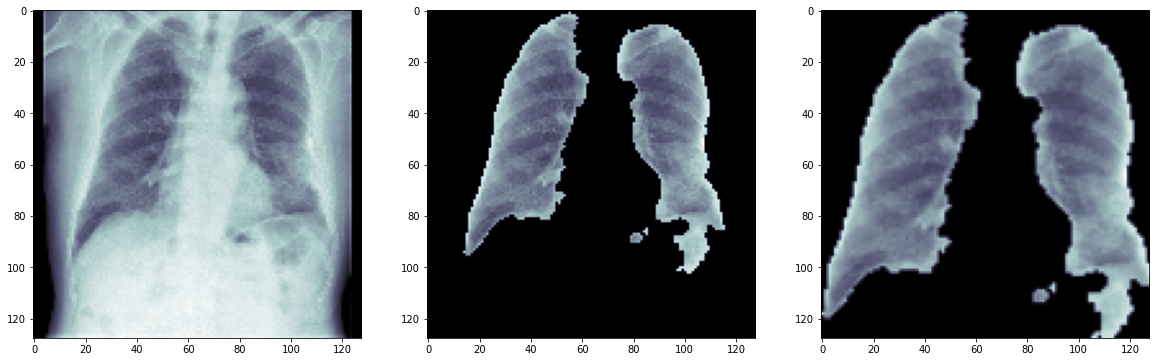

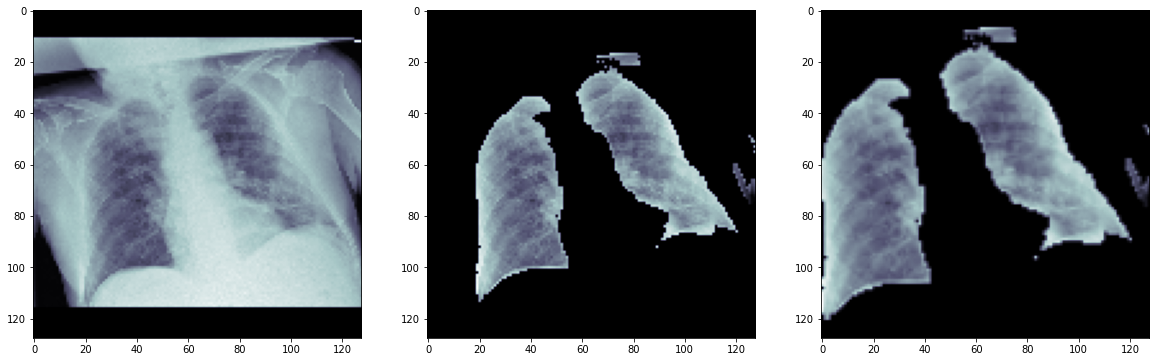

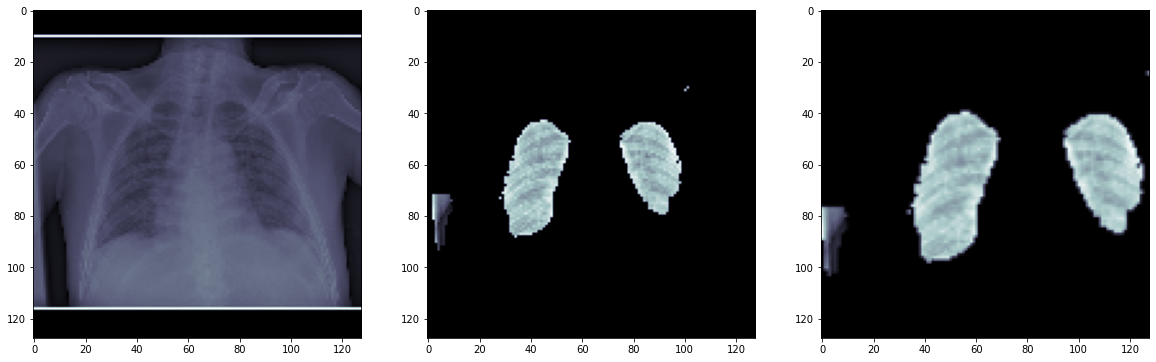

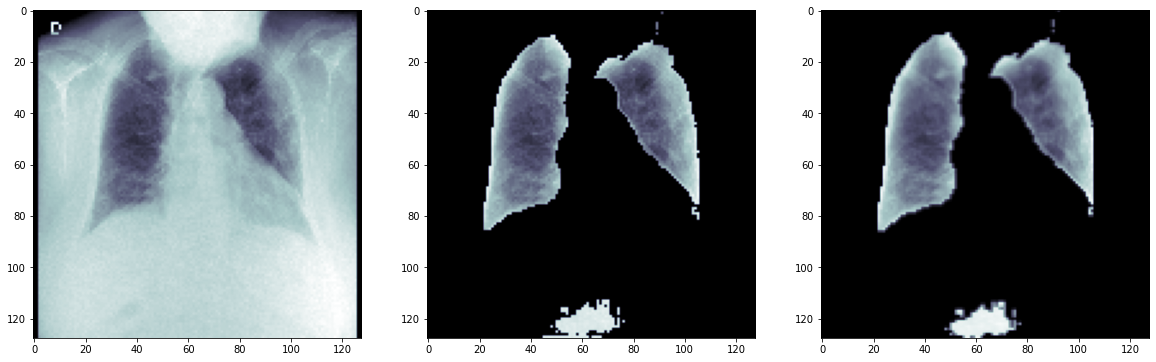

In [ ]:
show_prediction_on_new_data(0)
show_prediction_on_new_data(2) 
show_prediction_on_new_data(3)    
show_prediction_on_new_data(4)    